In [1]:
import tensorflow as tf
def inception_module(x,filters):
    F1,F2,F3,F4,F5,F6=filters
    conv1x1=tf.keras.layers.Conv2D(F1,(1,1),padding="same",activation="relu")(x)

    conv3x3=tf.keras.layers.Conv2D(F2,(1,1),padding="same",activation="relu")(x)
    conv3x3=tf.keras.layers.Conv2D(F3,(3,3),padding="same",activation="relu")(conv3x3)

    conv5x5=tf.keras.layers.Conv2D(F4,(1,1),padding="same",activation="relu")(x)
    conv5x5=tf.keras.layers.Conv2D(F5,(5,5),padding="same",activation="relu")(conv5x5)

    pool=tf.keras.layers.MaxPooling2D((3,3),strides=(1,1),padding="same")(x)
    pool=tf.keras.layers.Conv2D(F6,(1,1),padding="same",activation="relu")(pool)

    return tf.keras.layers.concatenate([conv1x1,conv3x3,conv5x5,pool],axis=-1)



2024-04-16 14:14:56.754156: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 14:14:56.785407: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 14:14:57.321656: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def inceptionV3(input_shape=(299,299,3),num_classes=1000):
    inputs=tf.keras.layers.Input(shape=input_shape)

    x=tf.keras.layers.Conv2D(16,(3,3),strides=(2,2),padding="valid",activation="relu")(inputs)
    x=tf.keras.layers.Conv2D(16,(3,3),padding="valid",activation="relu")(x)
    x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
    x=tf.keras.layers.MaxPooling2D((3,3))(x)

    x=tf.keras.layers.Conv2D(64,(1,1),padding="same",activation="relu")(x)
    x=tf.keras.layers.Conv2D(64,(3,3),padding="valid",activation="relu")(x)

    x = inception_module(x, [16, 32, 48,64, 32, 32])
    x = inception_module(x, [32, 64,128, 32, 32, 64])
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = inception_module(x, [128, 64, 128, 16, 32, 64])
    x = inception_module(x, [64, 112, 128, 24, 32, 64])
    x = inception_module(x, [128, 128, 256, 24, 64, 64])
    x = inception_module(x, [64, 128, 256, 32, 64, 64])
    x = inception_module(x, [128, 160, 256, 32, 64, 64])
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = inception_module(x, [128, 32, 256, 64, 64, 64])
    x = inception_module(x, [128, 32, 256, 32, 64, 64])

    x = tf.keras.layers.AveragePooling2D((7, 7))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs, outputs)
    return model

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255)
validation_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(
    '/home/developer/Desktop/brain tumor(3)/train',
    target_size=(299,299),
    batch_size=128,
    class_mode='sparse'
)

validation_generator=validation_datagen.flow_from_directory(
    '/home/developer/Desktop/brain tumor(3)/val',
    target_size=(299,299),
    batch_size=32,
    class_mode='sparse'
)
test_generator=test_datagen.flow_from_directory(
    '/home/developer/Desktop/brain tumor(3)/test',
    target_size=(299,299),
    batch_size=32,
    class_mode='sparse'
)

Found 21434 images belonging to 4 classes.
Found 1233 images belonging to 4 classes.
Found 3050 images belonging to 4 classes.


In [4]:
import matplotlib.pyplot as plt

def visualize_generator(generator, num_images=10):

    class_labels = list(generator.class_indices.keys())
    
    images, labels = next(generator)

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(images[i])
        plt.title(class_labels[int(labels[i])])
        plt.axis('off')
    plt.show()

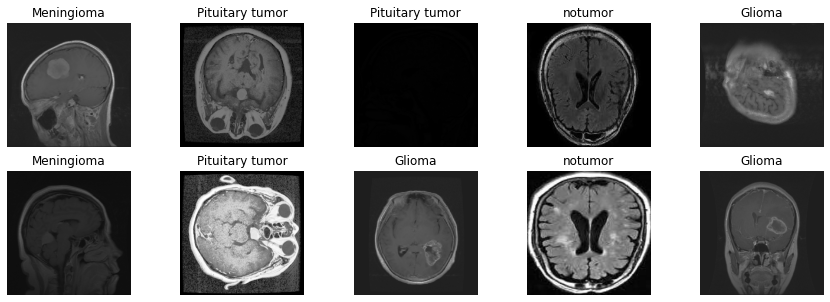

In [5]:
visualize_generator(train_generator,10)

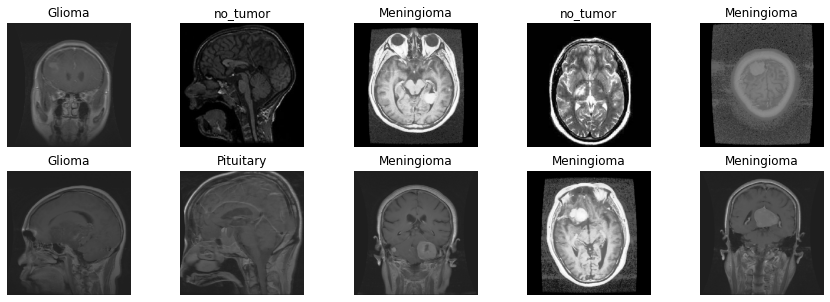

In [6]:
visualize_generator(test_generator,10)

In [3]:
model=inceptionV3(num_classes=4)

2024-04-16 14:15:07.153879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 14:15:07.159154: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-16 14:15:07.159850: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 147, 147, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 23, 23, 352)  0          ['concatenate_2[0][0]']          
                                                                                                  
 conv2d_23 (Conv2D)             (None, 23, 23, 64)   22592       ['concatenate_2[0][0]']          
                                                                                                  
 conv2d_25 (Conv2D)             (None, 23, 23, 128)  129152      ['conv2d_24[0][0]']              
                                                                                                  
 conv2d_27 (Conv2D)             (None, 23, 23, 32)   19232       ['conv2d_26[0][0]']              
                                                                                                  
 conv2d_28 (Conv2D)             (None, 23, 23, 64)   22592       ['max_pooling2d_5[0][0]']        
          

                                                                                                  
 conv2d_49 (Conv2D)             (None, 11, 11, 256)  73984       ['conv2d_48[0][0]']              
                                                                                                  
 conv2d_51 (Conv2D)             (None, 11, 11, 64)   102464      ['conv2d_50[0][0]']              
                                                                                                  
 conv2d_52 (Conv2D)             (None, 11, 11, 64)   32832       ['max_pooling2d_10[0][0]']       
                                                                                                  
 concatenate_7 (Concatenate)    (None, 11, 11, 512)  0           ['conv2d_47[0][0]',              
                                                                  'conv2d_49[0][0]',              
                                                                  'conv2d_51[0][0]',              
          

In [4]:
model.compile(loss=tf.losses.SparseCategoricalCrossentropy(),optimizer=tf.optimizers.Adam(),metrics=['accuracy'])

In [10]:

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath="best_model_inception.h5", monitor="val_accuracy", save_best_only=True)
csvlogger_callback=tf.keras.callbacks.CSVLogger('model_inception.csv', separator=",", append=True)
early_callback=tf.keras.callbacks.EarlyStopping(monitor="accuracy",patience=5)

In [11]:
history=model.fit(train_generator,epochs=10,validation_data=test_generator,callbacks=[model_checkpoint_callback,csvlogger_callback])


Epoch 1/10


2024-04-12 09:28:09.676306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-04-12 09:28:14.511542: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-04-12 09:28:15.184384: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-12 09:28:17.846847: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-12 09:28:17.853843: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x55d66755ec30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-12 09:28:17.853860: I tensorflo

168/168 [==============================] - ETA: 0s - loss: 1.0321 - accuracy: 0.4519

2024-04-12 09:29:50.988743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


168/168 [==============================] - 111s 482ms/step - loss: 1.0321 - accuracy: 0.4519 - val_loss: 0.8872 - val_accuracy: 0.5466
Epoch 2/10
168/168 [==============================] - 67s 399ms/step - loss: 0.8077 - accuracy: 0.6155 - val_loss: 0.7453 - val_accuracy: 0.7010
Epoch 3/10
168/168 [==============================] - 67s 396ms/step - loss: 0.6686 - accuracy: 0.7028 - val_loss: 0.5380 - val_accuracy: 0.7538
Epoch 4/10
168/168 [==============================] - 67s 394ms/step - loss: 0.5701 - accuracy: 0.7492 - val_loss: 0.4981 - val_accuracy: 0.8062
Epoch 5/10
168/168 [==============================] - 66s 394ms/step - loss: 0.5000 - accuracy: 0.7826 - val_loss: 0.3916 - val_accuracy: 0.8367
Epoch 6/10
168/168 [==============================] - 66s 391ms/step - loss: 0.4326 - accuracy: 0.8102 - val_loss: 0.3299 - val_accuracy: 0.8675
Epoch 7/10
168/168 [==============================] - 66s 391ms/step - loss: 0.4041 - accuracy: 0.8227 - val_loss: 0.3825 - val_accuracy: 0.

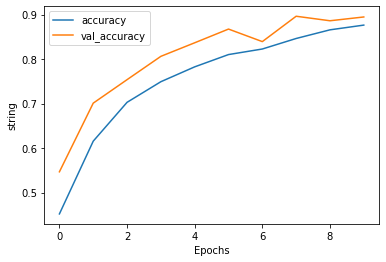

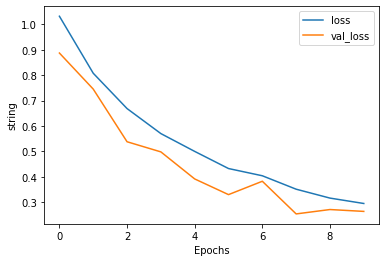

In [15]:
def plot_graphs(history,string):
    plt.plot(history.history[string],label=string)
    plt.plot(history.history['val_'+string],label='val_'+string)
    plt.xlabel("Epochs")
    plt.ylabel("string")
    plt.legend()
    plt.show()
plot_graphs(history,'accuracy')
plot_graphs(history,'loss')

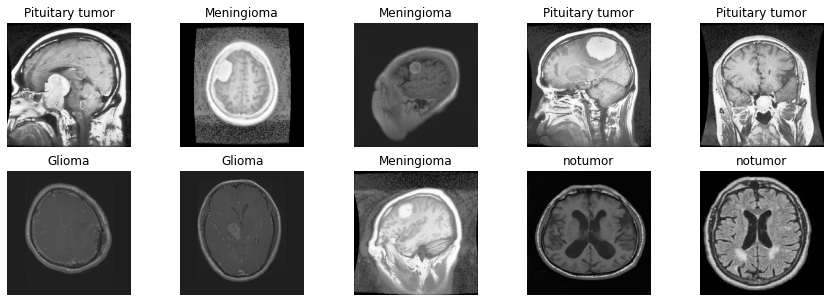

In [16]:
visualize_generator(validation_generator,10)

In [17]:
model.evaluate(validation_generator)


 2/39 [>.............................] - ETA: 2s - loss: 0.2089 - accuracy: 0.9062

2024-04-12 09:41:55.725593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


39/39 [==============================] - 3s 80ms/step - loss: 0.2474 - accuracy: 0.9084


[0.24737009406089783, 0.9083536267280579]

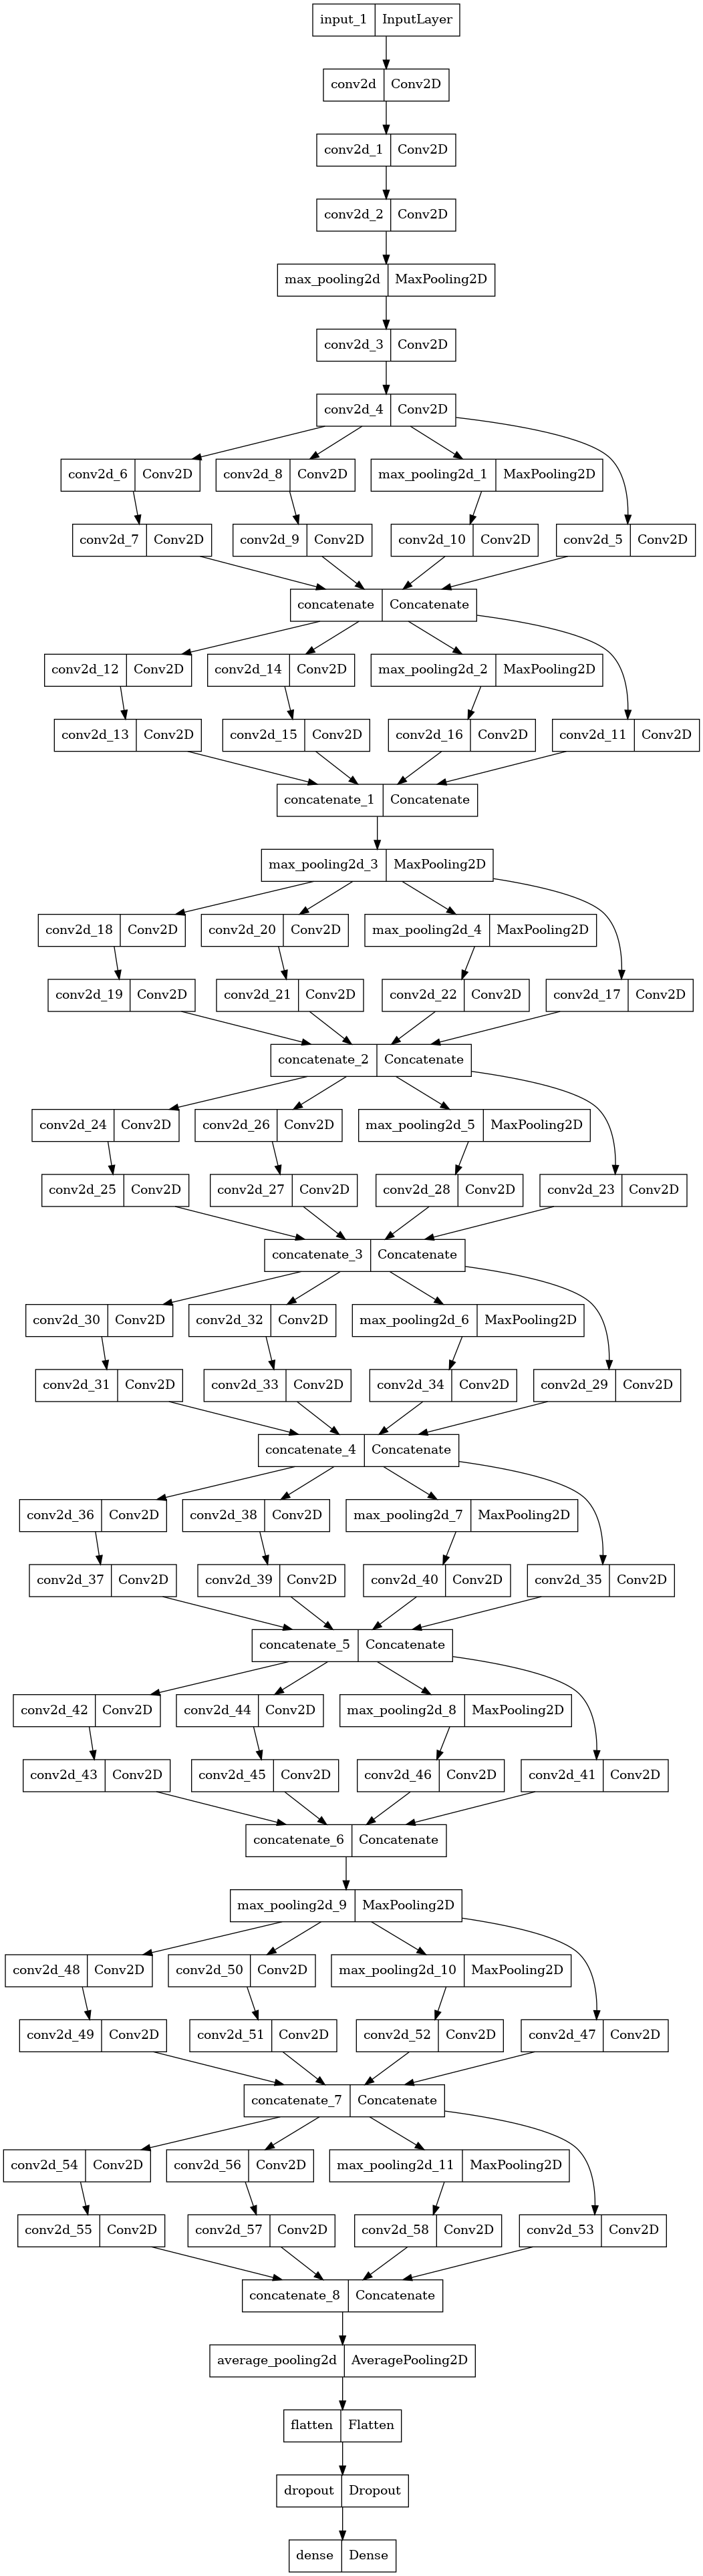

In [6]:
tf.keras.utils.plot_model(model,to_file="inceptionV3.png")